## PINN for DP using synthetic data

### Import libraries and packages

In [2]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
#from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.integrate import odeint

2025-08-28 10:12:01.225720: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 10:12:01.227200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 10:12:01.255387: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 10:12:01.256062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 10:12:01.723448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Generate synthetic data 
#### Using Ekenstam equation

In [3]:
def data_gen(A,E,R,T):
    def model(u,t):
        dudt = (-A*np.exp(-E/(R*T))*(u**2))*100*24*365*40  #scale according to time (24(hours)*365(days)*40(years)) and the intial condition (100)
        return dudt
  # initial condition
    u0 = 11
  # time points
    t = np.linspace(0,1,24) #24 data points, but can change for more or less
  # solve ODE
    u = odeint(model,u0,t)
    return t,u

### Define the PINN model and train

In [4]:
# Set up random seeds for replication of results
np.random.seed(seed=9267)
tf.random.set_seed(9267)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.sigmoid(tf.add(tf.matmul(A, W[i]), b[i])) #BE CAREFUL on the choice of activation function (sigmoid in this case since we use the natural logarithm)
    Y = tf.abs(tf.add(tf.matmul(A, W[-1]), b[-1]))
    return Y

# Trainable variables (weights and biases of the network and the parameters to estimate
def train_vars(W, b, ln_lambda1, lambda2):
    return W + b + ln_lambda1 + lambda2

# Network for DP (u in the code)
def net_u(t, w, b):
    u = DNN(tf.concat([t],1), w, b)
    return u

# Network for the residual 
@tf.function
def net_f(t,W, b, ln_lambda1, lambda2, DP_scale, t_scale, lb, ub):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net_u(t, W, b)
        u_log = tf.math.log(u)
    u_t = tape1.gradient(u_log, t)
    #ln_lambda1 = lb + (ub - lb)*(tf.tanh(ln_lambda1)) #these functions can be used to bound the values of the parameters (to keep them in certain ranges lb and ub)
    #lambda1 = lb + (ub - lb)*(tf.tanh(lambda2))
    f = u_t + ln_lambda1 - lambda2 + 2*u_log + tf.math.log(DP_scale) + tf.math.log(t_scale)  #residual function
    return f

#Training function
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, ln_lambda1, lambda2, R, T, DP_scale, t_scale, lb, ub):
    t = X_u_train_tf[:,0:1]
    t_f = X_f_train_tf[:,0:1]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,ln_lambda1,lambda2])
        u_nn = net_u(t, W, b) 
        f_nn = net_f(t, W, b, ln_lambda1, lambda2, DP_scale, t_scale, lb, ub)
        loss_data = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_ic = tf.reduce_mean(tf.square(u_nn[0] - u_train_tf[0]))  #not necessary
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss = loss_data + loss_ic + loss_f   # loss function
    grads = tape.gradient(loss, train_vars(W,b, ln_lambda1, lambda2))
    opt.apply_gradients(zip(grads, train_vars(W,b, ln_lambda1, lambda2)))
    return loss, loss_data, loss_ic, loss_f, ln_lambda1, lambda2



N_u = 300    #Number of data points (could be also just initial and boundary conditions)
N_f = 100    #Number of collocation points
Nmax= 50000  #Number of epochs

#Define the parameters of the residual 
A = tf.convert_to_tensor(3.42*10**8, dtype=tf.float32)  #parameter to estimate, so this value is just to compare the results
E = tf.convert_to_tensor(1.1*10**2, dtype=tf.float32)   #parameter to estimate, so this value is just to compare the results
R = tf.convert_to_tensor(8.314*10**(-3), dtype=tf.float32)
T = tf.convert_to_tensor(352, dtype=tf.float32)    #Kelvin
DP_scale = tf.convert_to_tensor(100, dtype=tf.float32)  #scaling value for the intial condition
t_scale = tf.convert_to_tensor(365*24*40, dtype=tf.float32)  # scaling value for time
l = E/(R*T)   #the scaled value we are considering to estimate E, just used to compare the results

#Network architecture
layers = [1, 50, 50, 50, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 
ln_lambda1 = [tf.Variable([19.0], dtype=tf.float32)]   #initialization of the scaled parameter A to estimate (ln_lambda1 = ln(A))
lambda2 = [tf.Variable([38.0], dtype=tf.float32)]      #initialization of the scaled parameter E to estimate (lambda2 = E/(RT))

#time and DP generation with odeint
t_star_syn, u_star_syn = data_gen(A,E,R,T)
t_star_gen = t_star_syn.astype(np.float32)
u_star_gen = u_star_syn.astype(np.float32)

t_star = t_star_gen.flatten()[:,None]
Exact_star = u_star_gen.flatten()[:,None] 

#Data with noise (we can define it here and decide later if use this or just the data without noise)
noise = 0.01  #percentage of noise, for experiments with added noise
Noise_star = Exact_star + noise*Exact_star.std(0)*np.random.randn(Exact_star.shape[0], Exact_star.shape[1])

# Domain bounds
lb = t_star.min(0)
ub = t_star.max(0)

#idx = np.random.choice(t_star.shape[0], N_u, replace=False)  #this is the index used if we want to use less data points from the dataset, but not used in this case
X_u_train = t_star#[idx, :]
u_train = Exact_star#[idx,:] #Here we can decide to use the exact data generated synthetically (Exact_star) pr the nopisy data (Noise_star)
X_f_train = lb + (ub-lb)*lhs(1, N_f)  #generating collocation points
X_f_train = np.vstack((X_f_train, X_u_train))  #the collocation points consist of the above generated collocation points and the data points

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)  #convert to tensor
u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)      #convert to tensor
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)  #convert to tensor

#Adam optimizer
lr = 1e-3
optimizer = tf.optimizers.legacy.Adam(learning_rate=lr)

#Training: We define empty lists to fill at each iteration with values for each loss function and estimated parameters
start_time = time.time()
n=0
loss = []
loss_data = []
loss_ic = []
loss_f = []
ln_lambda1_list = []
lambda2_list = []
while n <= Nmax:
    loss_, loss_data_, loss_ic_, loss_f_, ln_lambda1_list_, lambda2_list_ = train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, ln_lambda1, lambda2, R, T, DP_scale, t_scale, lb, ub)
    loss.append(loss_.numpy())  
    loss_data.append(loss_data_.numpy())  
    loss_ic.append(loss_ic_.numpy())
    loss_f.append(loss_f_.numpy()) 
    ln_lambda1_list.append(ln_lambda1_list_[0].numpy())
    lambda2_list.append(lambda2_list_[0].numpy())
    print(f"Iteration is: {n} and loss is: {loss_.numpy()} and lambda_1 is: {ln_lambda1_list_[0].numpy()} and lambda_2 is: {lambda2_list_[0].numpy()}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Iteration is: 0 and loss is: 121.12033081054688 and lambda_1 is: [19.001] and lambda_2 is: [37.999]
Iteration is: 1 and loss is: 118.2859115600586 and lambda_1 is: [19.001995] and lambda_2 is: [37.998005]
Iteration is: 2 and loss is: 115.60685729980469 and lambda_1 is: [19.002985] and lambda_2 is: [37.997017]
Iteration is: 3 and loss is: 113.0600357055664 and lambda_1 is: [19.003965] and lambda_2 is: [37.996037]
Iteration is: 4 and loss is: 110.62779235839844 and lambda_1 is: [19.004934] and lambda_2 is: [37.995068]
Iteration is: 5 and loss is: 108.29646301269531 and lambda_1 is: [19.00589] and lambda_2 is: [37.994114]
Iteration is: 6 and loss is: 106.05512237548828 and lambda_1 is: [19.006828] and lambda_2 is: [37.993176]
Iteration is: 7 and loss is: 103.89478302001953 and lambda_1 is: [19.007746] and lambda_2 is: [37.992256]
Iteration is: 8 and loss is: 101.80809783935547 and lambda_1 is: [19.00864] and lambda_2 is: [37.99136]
Iteration is: 9 and loss is: 99.78892517089844 and lambda

### PINN results

In [6]:
def predict(X_star_tf, w, b):
    t_star = X_star_tf[:,0:1]
    u_pred = net_u(t_star, w, b)
    return u_pred
    
t_star_tf = tf.convert_to_tensor(t_star.flatten()[:,None], dtype=tf.float32)    
u_pred = predict(t_star_tf, W, b)

# Errors estimations
error_u = np.linalg.norm(Exact_star-u_pred,2)/np.linalg.norm(Exact_star,2)
print('Error u: %e' %(error_u)) 
error_lambda1 = np.abs(ln_lambda1_list[-1] - np.log(A))/np.log(A)
print('Error A: %e' %(error_lambda1)) 
error_lambda2 = np.abs(lambda2_list[-1] - l)/l
print('Error E: %e' %(error_lambda2)) 

Error u: 8.175251e-03
Error A: 1.412483e-03
Error E: 5.595001e-03


### PINN results compared to data

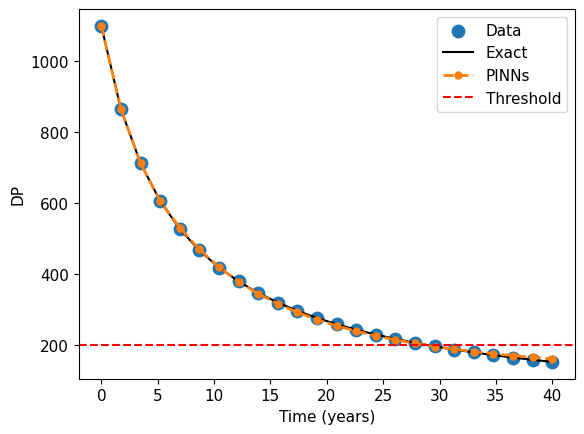

In [11]:
#fig = plt.figure(figsize=(6,4), dpi=150)
plt.scatter(t_star*40,Exact_star*100, label='Data',color='tab:blue',s=80, zorder=0)
plt.plot(t_star*40,Exact_star*100, label='Exact', color='black',zorder=1)
plt.plot(t_star*40,u_pred*100, 'tab:orange', label='PINNs', marker='.', markersize=10, linewidth='2', linestyle='--', zorder=2)
plt.axhline(y=200, color='r', linestyle='--', label='Threshold')
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Time (years)', size=11)
plt.ylabel('DP', size=11)
plt.legend(fontsize=11)
#plt.savefig('' + 'DP_pred_sim' + '.pdf', format="pdf", bbox_inches="tight")

### Loss functions

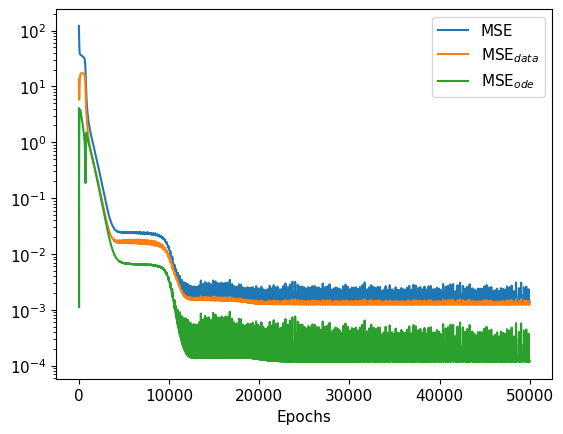

In [15]:
#fig = plt.figure(figsize=(6,4), dpi=150)
p = np.shape(loss)
ep = np.arange(p[0])
plt.semilogy(ep,loss, label='MSE')
plt.semilogy(ep,loss_data, label=r'MSE$_{data}$')
plt.semilogy(ep,loss_f, label=r'MSE$_{ode}$')
#plt.semilogy(ep,loss_ic, label='loss_ic')
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Epochs', size=11)
plt.legend(fontsize=11)
#plt.savefig('' + 'Losses_synthetic' + '.pdf', format="pdf", bbox_inches="tight")

### Plot for evolution of parameters over the pochs and losses 

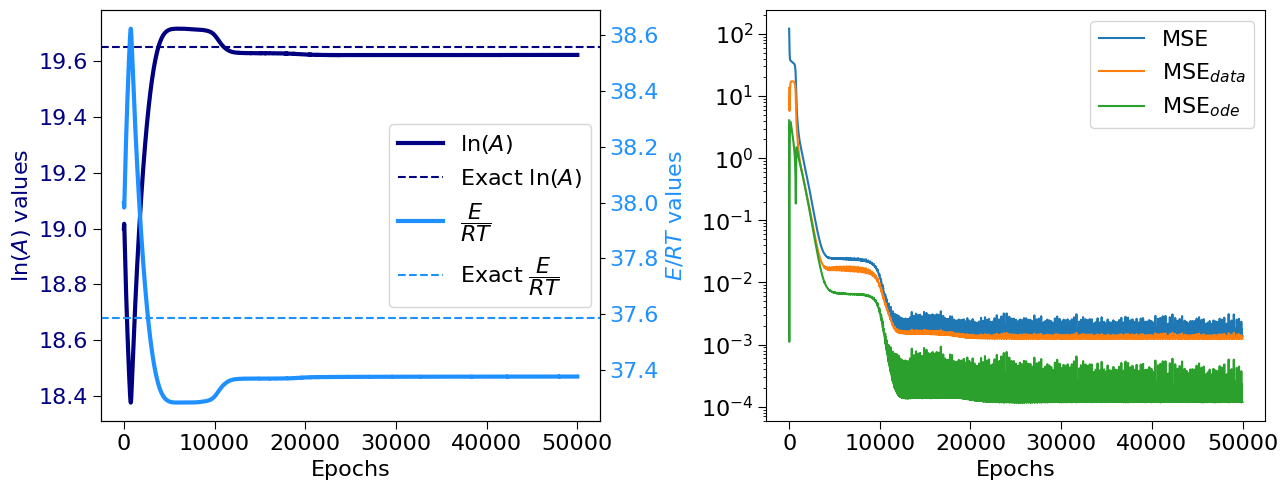

In [16]:
fig, axs = plt.subplots(1,2, figsize=(13,5))

color = 'navy'
axs[0].set_xlabel('Epochs', size=16)
axs[0].set_ylabel(r'ln($A$) values', color=color, size=16)
l1 = axs[0].plot(ln_lambda1_list, color=color, linewidth=3, label=r'ln($A$)')
l2 = axs[0].axhline(y=np.log(A), color=color, linestyle='--', label=r'Exact ln($A$)')
axs[0].tick_params(axis='y', labelcolor=color, labelsize=16, length=6)
axs[0].tick_params(axis='x', labelsize=16, length=6)

ax2 = axs[0].twinx()  # instantiate a second Axes that shares the same x-axis

color1 = 'dodgerblue'
ax2.set_ylabel(r'$E/RT$ values', color=color1, size=16)  # we already handled the x-label with ax1
l3 = ax2.plot(lambda2_list, color=color1, linewidth=3, label= r'$\dfrac{E}{RT}$')
l4 = ax2.axhline(y=l, color=color1, linestyle='--', label=r'Exact $\dfrac{E}{RT}$')
ax2.tick_params(axis='y', labelcolor=color1, labelsize=16)

p = np.shape(loss)
ep = np.arange(p[0])
axs[1].semilogy(ep,loss, label='MSE')
axs[1].semilogy(ep,loss_data, label=r'MSE$_{data}$')
axs[1].semilogy(ep,loss_f, label=r'MSE$_{ode}$')
axs[1].tick_params(axis='y', labelsize=16, length=6)
axs[1].tick_params(axis='x', labelsize=16, length=6)
axs[1].set_xlabel('Epochs', size=16)
axs[1].legend(fontsize=16)

lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center', bbox_to_anchor=(0.78,0.5), fontsize=16)

fig.tight_layout()
#plt.savefig('' + 'Params_losses_epochs_sim24' + '.pdf', format="pdf", bbox_inches="tight")

### ln(A) evolution over the epochs

Text(0, 0.5, 'ln(A) values')

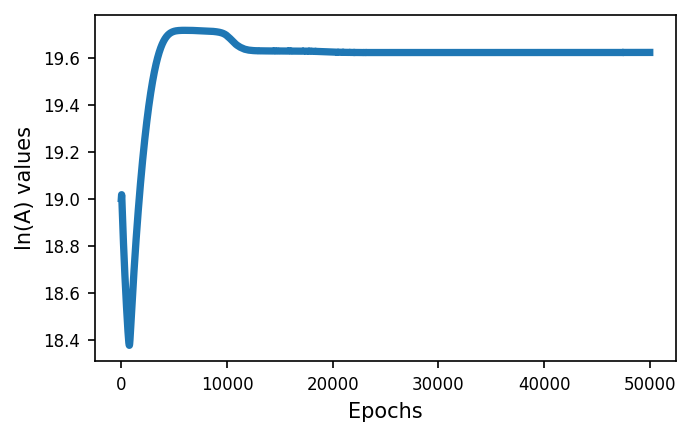

In [19]:
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(ln_lambda1_list, linewidth='3.5')
plt.xticks(size='8')
plt.yticks(size='8')
plt.xlabel('Epochs')
plt.ylabel('ln(A) values')
#plt.savefig('' + 'ln(A)_evolution_synthetic' + '.pdf', format="pdf", bbox_inches="tight")

### E/(RT) evolution over the epochs

Text(0, 0.5, 'E/RT values')

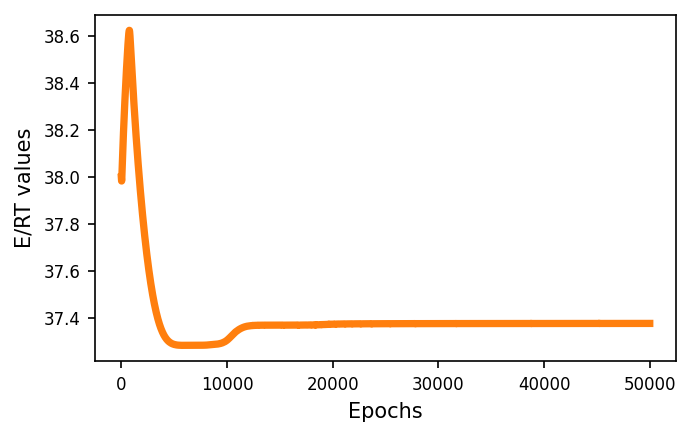

In [20]:
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(lambda2_list, 'tab:orange', linewidth='3.5')
plt.xticks(size='8')
plt.yticks(size='8')
plt.xlabel('Epochs')
plt.ylabel('E/RT values')
#plt.savefig('' + 'ERT_evolution_synthetic' + '.pdf', format="pdf", bbox_inches="tight")

### Scaled parameters evolution over the epochs in the same plot

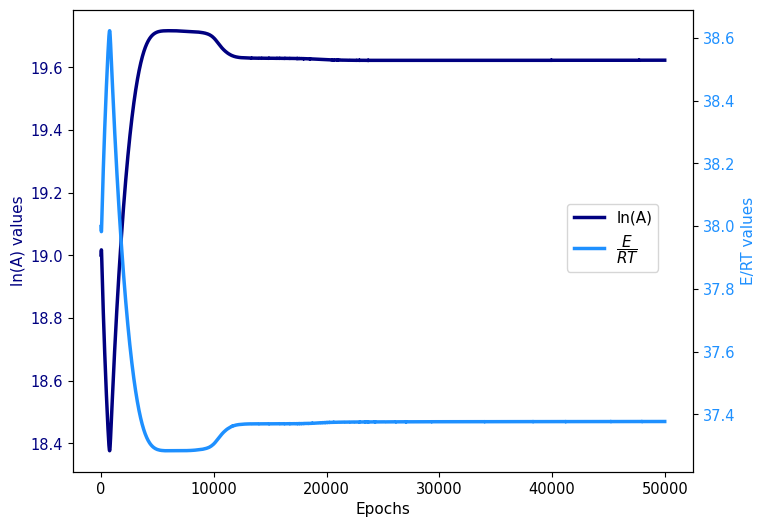

In [21]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'navy'
ax1.set_xlabel('Epochs', size=11)
ax1.set_ylabel('ln(A) values', color=color, size=11)
ax1.plot(ln_lambda1_list, color=color, linewidth=2.5, label='ln(A)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=10.5)
ax1.tick_params(axis='x', labelsize=10.5)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'dodgerblue'
ax2.set_ylabel('E/RT values', color=color, size=11)  # we already handled the x-label with ax1
ax2.plot(lambda2_list, color=color, linewidth=2.5, label= r'$\dfrac{E}{RT}$')
ax2.tick_params(axis='y', labelcolor=color, labelsize=10.5)

fig.legend(loc='center', fontsize=11, bbox_to_anchor=(0.8,0.5))

#plt.savefig('' + 'Parameters_evolution_synthetic' + '.pdf', format="pdf", bbox_inches="tight")